In [4]:
## import necessary libraries
import os
import sys
import json
import csv
import pandas as pd
import numpy as np
from collections import Counter
import random
import math
import nltk
from nltk.corpus import stopwords
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import gc

## garbage collection
gc.collect();

## load the dataframe of (mostly) raw tweets
input_file = '../../tweet_data/test_data/debate_data_unprocessed.pkl'
df = pd.read_pickle(input_file)

In [5]:
## delete the duplicates
Noriginal = len(df)
print 'initial number of tweets: ' + str(len(df))
df = df.drop_duplicates(subset='id', keep='last')
print 'duplicates deleted: ' + str(Noriginal - len(df))
df = df.reset_index(drop=True)
print 'current number of tweets: ' + str(len(df))

initial number of tweets: 821965
duplicates deleted: 239895
current number of tweets: 582070


In [6]:
## delete the retweets
print 'number of retweets deleted: ' + str(sum(list(df['retweet'])))
df = df[[not i for i in list(df['retweet'])]]

number of retweets deleted: 450424


In [7]:
## drop the non-English tweets (most dropped tweets seem to actually be English...)
lang_drop = (df['lang']!='en')
print 'non-English tweets deleted: ' + str(sum(lang_drop))
df = df[list([not i for i in lang_drop])]
df = df.reset_index(drop=True)
print 'current number of tweets: ' + str(len(df))

non-English tweets deleted: 0
current number of tweets: 131646


In [8]:
## sort the tweets by id, descending (chronological)
df = df.sort_values(by='id', ascending=1)
df = df.reset_index(drop=True)

In [9]:
## Preprocessing: set-up

## define a preprocessing function that 1) lowers the case, 2) tokenizes into words, 3) lemmatizes
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(sentence):
  return [wordnet_lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)]

## load the list of english stop words
stoplist = stopwords.words('english')

## set-up regular expressions to delete all non a-z characters
import re
regex = re.compile('[^a-zA-Z]')

## translation tables for dropping punctuation
## treat apostrophes differently from things like .,! also do not include _
import string
punctuation = string.punctuation
#punctuation = punctuation.replace('_', '')
punctuation_nospace = punctuation[6]
punctuation_space = [p for p in punctuation if p not in punctuation_nospace]
translate_table_nospace = dict((ord(char), None) for char in punctuation_nospace)   
translate_table_space = dict((ord(char), u' ') for char in punctuation_space)

## merge the tables
translate_table = translate_table_space.copy()
translate_table.update(translate_table_nospace) 

## load the list of emoticons
import codecs
f = codecs.open('../emoticons_positive.txt', encoding='utf-8')
pos_emoticons = []
for line in f:
  pos_emoticons.append(line[0:-1])
f = codecs.open('../emoticons_negative.txt', encoding='utf-8')
neg_emoticons = []
for line in f:
  neg_emoticons.append(line[0:-1])
all_emoticons = pos_emoticons + neg_emoticons
ASCII_all_emoticons = [e.encode("ascii","ignore") for e in all_emoticons]

## Preprocessing: implementation
words = []
new_text = []
for i in range(len(df)):
  text_dummy = df['text'].iloc[i]

  ## tokenize positive and negative emoticons
  ## also pad the token with spaces to catch even embedded tweets such as 'lame:('
  for j in range(len(pos_emoticons)):
    text_dummy = text_dummy.replace(pos_emoticons[j], ' posemoticontoken' + ' ')
  for j in range(len(neg_emoticons)):
    text_dummy = text_dummy.replace(neg_emoticons[j], ' negemoticontoken' + ' ')
  
  ## tokenize handles, hashtags, and url's
  text_dummy = text_dummy.replace('@', ' usernametoken') #this catches the '.@XXX' trick
  text_dummy = text_dummy.replace('#', ' hashtagtoken')
  while 'https://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('https://')] +' urltoken ' + text_dummy[text_dummy.index('https://')+23:]
  while 'http://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('http://')] +' urltoken ' + text_dummy[text_dummy.index('http://')+22:]
  
  ## replace html entities with space (note: 'and' is a stopword and so is dropped, so no need to treat & special)
  html_entities = [u'&nbsp;', u'&lt;', u'&gt;', u'&amp;', u'&quot;', u'&apos;', u'&cent;', u'&pound;', u'&yen;', u'&euro;', u'&copy;', u'&reg;']
  for html in html_entities:
    text_dummy = text_dummy.replace(html, '')
  
  ## drop punctuation, tokenize into words, lower the case, and lemmatize
  text_dummy = text_dummy.translate(translate_table)
  words_dummy = preprocess(text_dummy)

  ## remove stop words
  words_dummy = [w for w in words_dummy if not w in stoplist]
  
  ## anonymize the username_tokens
  for j in range(len(words_dummy)):
    if words_dummy[j][0:13] == 'usernametoken':
      words_dummy[j] = 'usernametoken'

  ## remove numbers
  words_dummy = [regex.sub('', w) for w in words_dummy if len(regex.sub('', w)) > 0]
  
  ## make a new sentence for easy vectorized manipulations
  words.append(words_dummy)
  new_text.append(" ".join(words_dummy))
df['words'] = words
df['new_text'] = new_text

In [10]:
## emoticon statistics
pos_emoticon_counter = 0
neg_emoticon_counter = 0
for i in range(len(df)):
  pos_emoticon_counter += Counter(df['words'].iloc[i])['posemoticontoken']
  neg_emoticon_counter += Counter(df['words'].iloc[i])['negemoticontoken']

print 'avg. positive emoticons per tweet:', float(pos_emoticon_counter)/len(df)
print 'avg. negative emoticons per tweet:', float(neg_emoticon_counter)/len(df)

avg. positive emoticons per tweet: 0.00481594579402
avg. negative emoticons per tweet: 0.00294729805691


number of tweets: 131646

training set statistics:
  total number of words: 1344132
  total number of unique words: 50175
  lexical diversity: 0.0373289230522


+-------------------------+-------+
| Word                    | Count |
+-------------------------+-------+
| usernametoken           | 91363 |
| urltoken                | 88321 |
| hashtagtokendebates     | 81678 |
| trump                   | 34299 |
| vote                    | 24078 |
| hillary                 | 21854 |
| think                   | 20492 |
| hashtagtokendebatenight | 19985 |
| told                    | 18041 |
| winning                 | 17985 |
| cast                    | 17741 |
| hashtagtokennbcdc       | 17650 |
| debate                  | 11966 |
| clinton                 | 11613 |
| donald                  |  7534 |
| hashtagtokentrump       |  7080 |
| hashtagtokendebate      |  5492 |
| wa                      |  5150 |
| u                       |  4800 |
| ha                      |  4726 |
+----------

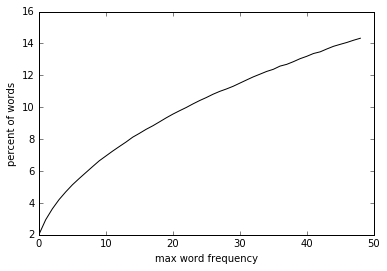

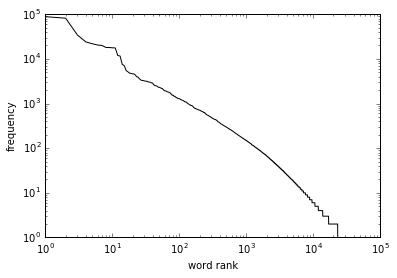

In [11]:
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

## print out some preliminary statistics
print 'number of tweets: ' + str(len(df))

## lexical diversity
def lexical_diversity(tokens):
    return 1.0*len(set(tokens))/len(tokens) 

print '\ntraining set statistics:'
print '  total number of words:', len(words_tot)
print '  total number of unique words:', len(words_unique)
print '  lexical diversity:', lexical_diversity(words_tot)

## examine word frequencies
print '\n'
pt = PrettyTable(field_names=['Word', 'Count']) 
[ pt.add_row(kv) for kv in count[:20] ]
pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

## get a sense for the frequency distribution of words
## what % of words occur with frequency <= x
maxwordfreq = [100.0*c*words_frequencies.count(c)/len(words_tot) for c in range(1,50)]
for i in range(1,len(maxwordfreq)):
  maxwordfreq[i] += maxwordfreq[i-1]
%matplotlib inline
plt.plot(maxwordfreq, c='black')
plt.ylabel('percent of words')
plt.xlabel('max word frequency')
plt.show()

## plot frequency(rank)
words_tot_counts = sorted(Counter(words_tot).values(), reverse=True)
plt.loglog(words_tot_counts, c='black')
plt.ylabel('frequency')
plt.xlabel('word rank')
plt.show()

In [12]:
## save the processed data
output_file = '../../tweet_data/test_data/debate_data_processed.pkl'
df_final = df.copy(deep=True)
df_final = df_final.drop([l for l in list(df.columns.values) if l not in ['id','sentiment','words','event date','text','created_at']], axis=1)
df_final.to_pickle(output_file)